# Analysis of summary motility metrics in pools
---

#### Overview

This notebook utilizes the summary motility metrics computed from individual cell trajectories (generated in [`1_compute-summary-motility-metrics.ipynb`](./1_compute-summary-motility-metrics.ipynb)) to explore the effects of certain experimental variables on motility.

The experimental variables explored here include the amount of time the cells spent in water prior to imaging and the position in the tube the cells were extracted from. To better understand why these experimental variables were chosen and the parameter space they encompass, please refer to Figure 1 of the [pub](https://doi.org/10.57844/arcadia-2d61-fb05).

For each experimental variable, we generate univariate kernel density estimate (KDE) plots for several motility metrics to draw comparisons between e.g. motility of cells that spent 4 hours in water vs those that spent 21 hours in water prior to imaging. We then plot joint distributions to enable the same comparisons between experimental variables but for two separate motility metrics simultaneously. Plots are annotated to denote statistical significance: "*" indicates p ≤ 0.05; "ns" indicates p > 0.05.

Output from this notebook was used to generate Figure 5 in the [pub](https://doi.org/10.57844/arcadia-2d61-fb05).

In [1]:
import string
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from chlamytracker.stats_testing import joint_grid_with_stats, split_violin_plot_with_stats

Configure matplotlib styles to match the Arcadia style guide

In [2]:
import arcadia_pycolor as apc

apc.mpl.setup()

## Load motility metrics
---

Load summary motility metrics from all _C. Reinhardtii_ cells swimming in pools. This data is stored in `../data/AMID-04_summary_motility_metrics.csv`, which was generated by running [`1_compute-summary-motility-metrics.ipynb`](./1_compute-summary-motility-metrics.ipynb).

#### Experimental parameters

| strain   | vessel type | position in tube | time in water |
|----------|-------------|------------------|---------------|
| CC-124   | pools       | top              | 4 hrs         |
|          |             | middle           | 21 hrs        |

Strain [CC-124](https://www.chlamycollection.org/product/cc-124-wild-type-mt-137c/) corresponds to _C. Reinhardtii_.

#### Collect csv files

In [3]:
# read csv
csv_file = Path("../data/AMID-04_summary_motility_metrics.csv")
motility_metrics_dataframe = pd.read_csv(csv_file)

# preview
motility_metrics_dataframe.drop(["slide_ID", "well_ID"], axis=1).groupby(
    ["position_in_tube", "time_in_water"]
).head(2)

,total_time,total_distance,net_distance,max_sprint_length,confinement_ratio,mean_curvilinear_speed,mean_linear_speed,mean_angular_speed,num_rotations,num_direction_changes,pivot_rate,cell_count,experiment_ID,strain,vessel_type,position_in_tube,time_in_water,timelapse_ID,pool_ID
0,14.60292,723.059408,51.339131,22.719548,0.071003,49.514714,3.515676,3.595302,0.0,33,0.045639,1,AMID-04,cc124,pools,top,21,1,2x0
1,10.10202,420.157509,91.028098,16.674224,0.216652,41.591435,9.010881,3.086678,0.0,17,0.040461,1,AMID-04,cc124,pools,top,21,1,3x0
83,12.55251,194.253793,17.959306,6.741264,0.092453,15.475295,1.430734,3.626716,2.0,31,0.159585,1,AMID-04,cc124,pools,middle,21,4,0x0
84,19.95399,449.436363,53.439939,9.120043,0.118904,22.523634,2.678158,5.417029,1.0,57,0.126826,1,AMID-04,cc124,pools,middle,21,4,2x3
119,15.05301,453.167671,78.331209,13.325166,0.172853,30.104788,5.203691,4.866694,4.0,47,0.103714,1,AMID-04,cc124,pools,top,4,1,3x0
120,19.95399,208.840261,8.935551,4.954940,0.042787,10.466090,0.447808,5.191020,7.0,68,0.325608,1,AMID-04,cc124,pools,top,4,3,2x1
141,19.90398,423.901283,49.489268,7.501952,0.116747,21.297313,2.486401,2.241343,1.0,24,0.056617,1,AMID-04,cc124,pools,middle,4,2,2x1
142,14.25285,401.621388,28.424880,12.219971,0.070775,28.178321,1.994330,4.432062,2.0,44,0.109556,1,AMID-04,cc124,pools,middle,4,8,4x2


## 1D analysis
---

#### Define experimental variables and motility metrics

In [4]:
# set metrics
metrics_subset = [
    "confinement_ratio",
    "mean_curvilinear_speed",
    "mean_angular_speed",
]

# set experimental variables
experimental_variables = [
    "position_in_tube",
    "time_in_water",
]

# set color palettes in accordance with experimental variables
palettes = {
    "time_in_water": ["#73B5E3", "#377BB7"],
    "position_in_tube": ["#B5BEA4", "#596F74"],
    "vessel": ["#F28360", "#7A77AB"],
}

#### Split violin plots
Generate univariate KDE plots (in this case, split violins) of chosen motility metrics for cells grouped by each specified experimental variable.

In the plots below, the top row shows distributions of max sprint length, mean curvilinear speed, and mean angular speed for cells pipetted from the top of the tube (light green) versus the middle of the tube (dark green). The bottom row shows distributions of the same metrics for cells that spent 4 h in water (light blue) vs 21 h in water (dark blue) before imaging.

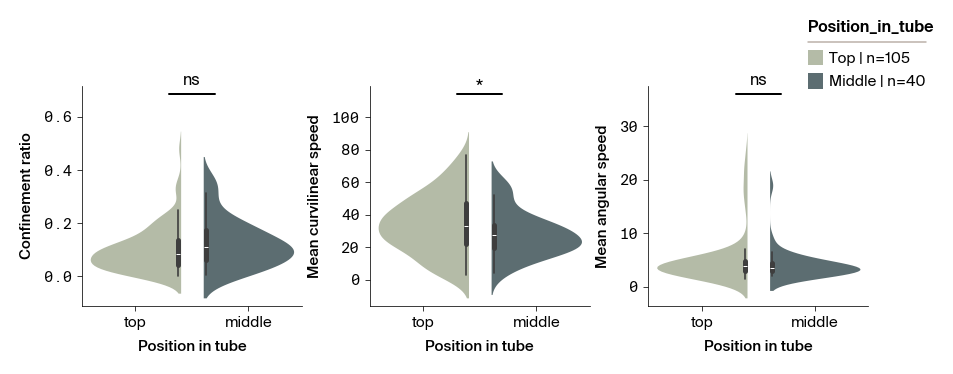

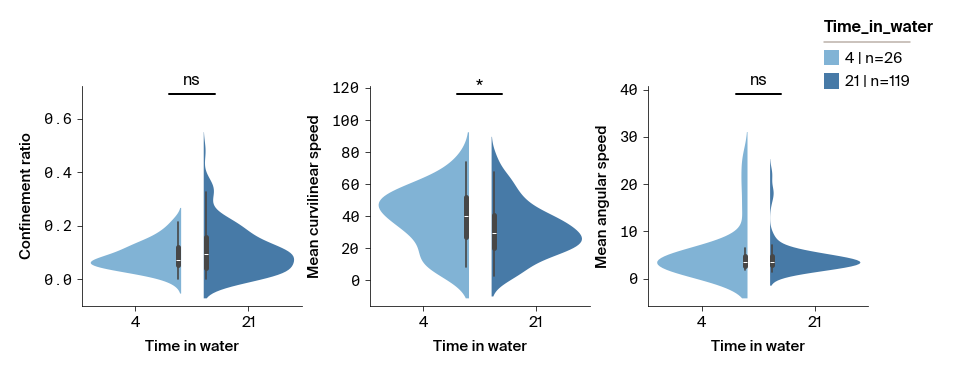

In [5]:
source = motility_metrics_dataframe.copy()

# loop through experimental variables
for k, experimental_variable in enumerate(experimental_variables):
    # create figure
    ncols = len(metrics_subset)
    figsize = apc.mpl.get_figure_dimensions("full_wide")
    fig, axes = plt.subplots(
        ncols=ncols,
        figsize=figsize,
        layout="constrained",
    )

    # loop through select metrics
    for i, metric in enumerate(metrics_subset):
        # create only one legend for the figure
        last = len(metrics_subset) - 1
        legend = True if i == last else False

        # render violin plot
        ax = split_violin_plot_with_stats(
            data=source,
            x_variable=experimental_variable,
            y_variable=metric,
            hue_variable=experimental_variable,
            palette=palettes[experimental_variable],
            inner="box",
            inner_kws={"box_width": 5},
            fill=True,
            legend=legend,
            ax=axes.flat[i],
        )

        # monospace numerical axes
        apc.mpl.style_plot(ax, monospaced_axes="y")
        # replace underscores with space in axes titles
        xlabel = ax.xaxis.label.get_text()
        ylabel = ax.yaxis.label.get_text()
        ax.set_xlabel(xlabel.replace("_", " "))
        ax.set_ylabel(ylabel.replace("_", " "))

    # reposition and stylize the legend
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1.3))
    apc.mpl.style_plot(ax)

    # save figure
    panel = string.ascii_uppercase[k]
    apc.mpl.save_figure(f"../results/figure-5{panel}.svg")

## 2D analysis
---

#### Bivariate distributions
Generate scatter plots of chosen motility metrics for cells grouped by each specified experimental variable. In the plots below, each axis corresponds to a certain motility metric to visualize distributions of e.g. mean curvilinear speed vs confinement ratio for cells grouped by the time they spent in water prior to imaging. One dimensional KDE plots are generated along the margins of each plot.

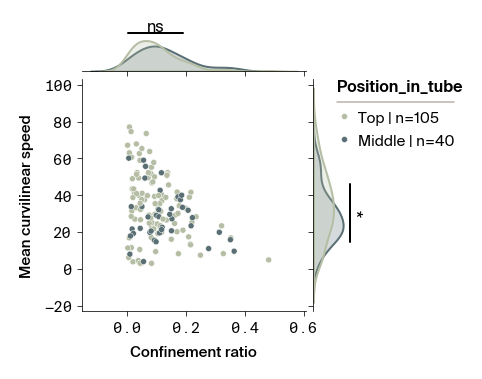

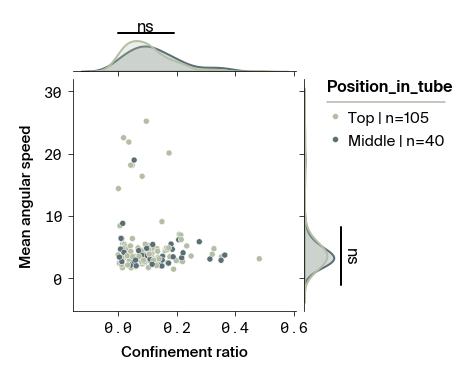

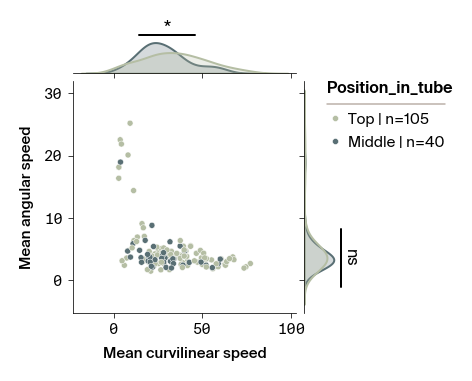

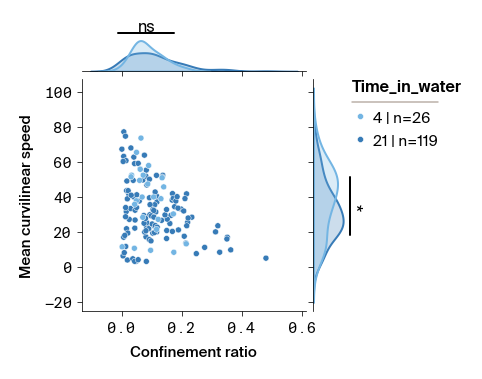

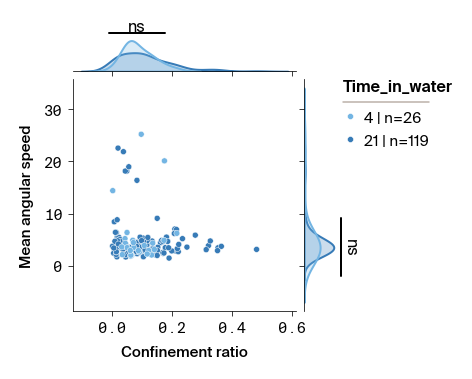

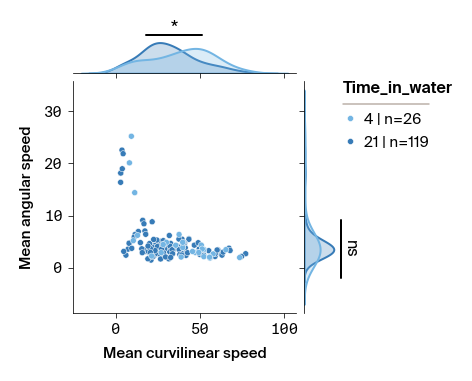

In [6]:
metrics_combinations = list(combinations(metrics_subset, 2))
source = motility_metrics_dataframe.copy()

# loop through experimental variables
for experimental_variable in experimental_variables:
    # loop through combinations of motility metrics
    for metric_i, metric_j in metrics_combinations:
        # render joint distributions with stats
        g = joint_grid_with_stats(
            data=source,
            x_variable=metric_i,
            y_variable=metric_j,
            hue_variable=experimental_variable,
            palette=palettes[experimental_variable],
            height=5,
        )

        # replace underscores with space in axes titles
        xlabel = g.ax_joint.xaxis.label.get_text()
        ylabel = g.ax_joint.yaxis.label.get_text()
        g.ax_joint.set_xlabel(xlabel.replace("_", " "))
        g.ax_joint.set_ylabel(ylabel.replace("_", " "))
        # aesthetics
        sns.move_legend(g.ax_joint, "upper right", bbox_to_anchor=(1.7, 1))
        apc.mpl.style_plot(g.ax_joint, monospaced_axes="both")